In [31]:
import mdtraj as md
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Basics

## Load trajectory

In [4]:
# To load files that don’t contain topology information, we need to supply something with the top keyword argument
traj = md.load('/DURF_datasets/triad_molecule/triad_dataset.nc', top= '/DURF_datasets/triad_molecule/triad_forcefield_ground.prmtop')
print(traj)

<mdtraj.Trajectory with 100000 frames, 207 atoms, 1 residues, and unitcells>


## Slice the frames

In [5]:
# Pretty much like slicing a list
print(traj[:10])
print(traj[:10:2])

<mdtraj.Trajectory with 10 frames, 207 atoms, 1 residues, and unitcells>
<mdtraj.Trajectory with 5 frames, 207 atoms, 1 residues, and unitcells>


## Save traj back to disk

In [6]:
# The format will be parsed based on the extension
# Choose several frames for the tutorial, try not to touch the full dataset
traj[::10000].save('/DURF_datasets/triad_molecule/for_tutorial.h5')

In [7]:
# Load the subset for tutorial
traj = md.load('/DURF_datasets/triad_molecule/for_tutorial.h5')

## # of atoms, residues, and frames

In [8]:
print(traj.n_atoms)
print(traj.n_residues)
print(traj.n_frames)

207
1
10


## Cartesian coordinates

In [9]:
# The Cartesian coordinates are stored in an ndarray xyz
print (traj.xyz.shape)
# Display the coordinate of the 8th atom at the 5th frame
print(tuple(traj.xyz[4,7,:]))

(10, 207, 3)
(5.6700797, 3.2196846, 4.0595813)


# Topology Object

## Topology
The `Topology` of a `Trajectory` contains all the connectivity information of your system and specific chain, residue, and atom information

In [10]:
top = traj.topology
top

<mdtraj.Topology with 1 chains, 1 residues, 207 atoms, 247 bonds at 0x1897c8f0940>

## Select an atom / loop through atoms

In [11]:
# Select the 4th atom
print(top.atom(3)) # Index starts from 0
# Loop through the first 20 atoms
print([atom for atom in top.atoms if atom.index < 20])

TRI0-C4
[TRI0-C1, TRI0-C2, TRI0-C3, TRI0-C4, TRI0-C5, TRI0-C6, TRI0-C7, TRI0-C8, TRI0-C9, TRI0-C10, TRI0-C11, TRI0-C12, TRI0-C13, TRI0-C14, TRI0-C15, TRI0-C16, TRI0-C17, TRI0-C18, TRI0-C19, TRI0-C20]


## Properties of atoms
- index
- name
- element
    - mass
    - name
    - symbol
    - number (atomic)
    - radius
- n_bonds

In [12]:
# Want to see the # of bonds for the 5th atom
atom = top.atom(4)
atom.n_bonds

3

# Analysis

## RMSD Analysis
Basic syntax: `md.rmsd(target_traj, reference_conformation, frame_num, atom_indices)`

3rd and 4th arguments are optional: if the reference is a trajectory, then you need to give the frame num. Atom_indices are given when you want to select atoms for the calculation

### Pairwise RMSD
Compute the RMSD value for each two pairs of conformation

In [13]:
# Create a numpy array to store all the values
# One loop will produce the same quantity of values as frame number
# Loop for (n_frames time) to cover all the conbinations
distances = np.empty((traj.n_frames, traj.n_frames))
for i in range(traj.n_frames):
    distances[i] = md.rmsd(traj, traj, i)
pd.DataFrame(distances)

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.366514,0.530243,0.685211,0.637866,0.474290,0.621992,0.575354,0.438588,0.491408
1,0.366516,0.000000,0.505941,0.719797,0.472186,0.459605,0.551277,0.476775,0.446234,0.509999
2,0.530243,0.505941,0.000000,0.580467,0.527394,0.439379,0.614798,0.524209,0.430268,0.466283
3,0.685212,0.719797,0.580466,0.000000,0.872281,0.768772,1.018840,0.913994,0.656724,0.881711
4,0.637864,0.472183,0.527395,0.872281,0.000000,0.372797,0.469098,0.350479,0.419442,0.523004
5,0.474290,0.459604,0.439379,0.768772,0.372797,0.000000,0.454910,0.503081,0.256254,0.494223
6,0.621992,0.551270,0.614797,1.018840,0.469098,0.454910,0.000000,0.431566,0.594019,0.384573
7,0.575354,0.476771,0.524210,0.913994,0.350475,0.503084,0.431566,0.000000,0.545555,0.308000
8,0.438588,0.446234,0.430268,0.656724,0.419443,0.256256,0.594019,0.545555,0.000000,0.560115
9,0.491408,0.509999,0.466284,0.881711,0.523004,0.494223,0.384573,0.308000,0.560116,0.000000


The rmsd results are the same when you exchange the target and reference. It is obvious that the results are symmetric along the diagonal, so almost half of the values are repetitive. Maybe a better version:

In [14]:
distances = np.empty((traj.n_frames, traj.n_frames))
for i in range(traj.n_frames):
    distances[i] = np.concatenate((np.zeros((i+1,), dtype = float),md.rmsd(traj[i+1:], traj, i)))
for i in range(traj.n_frames):    
    for j in range(i+1, traj.n_frames):
        distances[j,i] = distances[i,j]
pd.DataFrame(distances)

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.366515,0.530243,0.685212,0.637864,0.474290,0.621992,0.575353,0.438589,0.491407
1,0.366515,0.000000,0.505941,0.719797,0.472186,0.459604,0.551277,0.476775,0.446234,0.509999
2,0.530243,0.505941,0.000000,0.580467,0.527394,0.439379,0.614798,0.524209,0.430268,0.466283
3,0.685212,0.719797,0.580467,0.000000,0.872281,0.768772,1.018840,0.913994,0.656724,0.881711
4,0.637864,0.472186,0.527394,0.872281,0.000000,0.372797,0.469100,0.350479,0.419442,0.523004
5,0.474290,0.459604,0.439379,0.768772,0.372797,0.000000,0.454910,0.503081,0.256254,0.494223
6,0.621992,0.551277,0.614798,1.018840,0.469100,0.454910,0.000000,0.431566,0.594019,0.384573
7,0.575353,0.476775,0.524209,0.913994,0.350479,0.503081,0.431566,0.000000,0.545555,0.308000
8,0.438589,0.446234,0.430268,0.656724,0.419442,0.256254,0.594019,0.545555,0.000000,0.560115
9,0.491407,0.509999,0.466283,0.881711,0.523004,0.494223,0.384573,0.308000,0.560115,0.000000


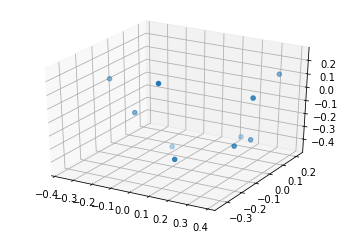

In [35]:
fig = plt.figure()
ax = plt.axes(projection = '3d')
x = a.T[0]
y = a.T[1]
z = a.T[2]
ax.scatter(x, y, z, 'green')